In [1]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
import os

from matplotlib.patches import Rectangle

from PIL import Image, UnidentifiedImageError

import numpy as np

import glob

import sys

from PIL.ExifTags import TAGS #Dicionario chave/descricao dos metadatas padroes das imagens de formato jpg 

import exif

from keras.models import load_model

# develop a classifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

from random import choice

#Para serializar e deserializar os modelos ML treinados
import pickle

0.1.0


In [2]:
#Definicao do repertorio home do projet
os.chdir("C:\\Users\\Utilisateur\\Downloads\\tmp\\FACES\\")
#os.chdir("G:\\Meu Drive\\tmp\\FACES\\")
#os.chdir("G:\\Mon Drive\\tmp\\FACES\\")
#Parametros
sizeImg = 128

In [3]:
#globals().has_key()
dicTest = globals()
type(dicTest)
dicTest
'sizeImg2' in globals()

False

In [4]:
# create the detector, using default weights
detector = MTCNN()

In [5]:
# draw an image with detected objects
def plotImageComRostos(dataImg, lstDicRosto, lstLabelPredRosto=None, lstProbPredRosto=None, limProbLabel = 0.8):

    # plot the image
    pyplot.imshow(dataImg)
    # recuperacao do contexto do grafico da imagem para plotar os rostos encima
    ax = pyplot.gca()
    # plot cada rosto
    for i in range(len(lstDicRosto)):
        #print(i)
        # get coordinates
        x, y, width, height = lstDicRosto[i]['coord']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        
        #Caso a probabilidade esta superior a um treshold, se adiciona um texto com o label da classe rosto e a probabilidade
        if (lstProbPredRosto is not None and lstProbPredRosto[i] >= limProbLabel):
            centerx = x # obviously use a different formula for different shapes
            centery = y # obviously use a different formula for different shapes
            txtRosto =  lstLabelPredRosto[i]+'\n'+str(lstProbPredRosto[i])
            #fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
            #fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
            #fontweight or weight: {a numeric value in range 0-1000, 'ultralight', 'light', 'normal', 'regular', 'book', 'medium',
            #    'roman', 'semibold', 'demibold', 'demi', 'bold', 'heavy', 'extra bold', 'black'}
            pyplot.text(centerx, centery, txtRosto, alpha=1, color='red', \
                        fontfamily='sans-serif', fontsize='medium', fontweight='bold')
        
    fig = ax.figure
    fig.set_size_inches((10,10))
    # show the plot
    pyplot.show()

In [6]:
# extract the faces from a given photograph
def extracaoRostos(detector, nameFile, dataImg, pathRosto, sizeRosto = (224, 224) ):
    lstDicRosto = list()
    
    # Detecao dos rostos a parte dos dados da imagem passada em parametro
    lstResultRostos = detector.detect_faces(dataImg)
    
    for i, resultRosto in enumerate(lstResultRostos):
        #Se tem uma boa probabilidade que o pedaco de imagem separado seja um rosto
        if resultRosto['confidence'] > 0.9:
            #Recuperacao das coordenadas da area do rosto identificado
            x1, y1, width, height = resultRosto['box']
            x2, y2 = x1 + width, y1 + height
            #Extracao dos dados do rosto
            dataRosto = dataImg[y1:y2, x1:x2]
            #Se redimensiona o rosto com o tamanho passado em parametro
            # Para isso, se passa no formato de imagem
            imgRosto = Image.fromarray(dataRosto)
            # e se redimensiona a parte do formato imagem
            imgRosto = imgRosto.resize(sizeRosto)
            # Volta em array da imagem de rosto redimensionada
            dataRosto = np.asarray(imgRosto)
            
            #Dicionario do rosto com os dados e as coordenadas
            dicRosto = {'data': dataRosto, 'coord': resultRosto['box']}
            
            #Se adiciona a lista de retorno da funcao
            lstDicRosto.append(dicRosto)   
            
            #Se o path do repertorio de conservacao dos rostos esta passado em parametro a funcao, 
            # se salva os dados do rosto em um arquivo de imagem de nome derivado do nome da foto original
            if pathRosto is not None:
                nomeSemExt = os.path.splitext(nameFile)[0]
                #nomeSemExt
                extNome = os.path.splitext(nameFile)[1]
                #extNome
                newName = pathRosto+'/'+nomeSemExt+'_FACE'+str(i)+extNome
                #newName
                pyplot.imsave(newName, dataRosto)
            
            # Plot o rosto extraido
            if pathRosto is not None:
                title = newName+'-'+str(round(resultRosto['confidence'], 2))
            else:
                title = str(round(resultRosto['confidence'], 2))
            pyplot.subplot(1, len(lstResultRostos), i+1, title=title)
            pyplot.imshow(dataRosto)
            pyplot.gca().figure.set_size_inches((19,12))
            pyplot.axis('off')
            
    # show the plot
    pyplot.show()

    return lstDicRosto

In [7]:
# Criacao do objeto de detecao de rostos, usando os pesos por default
detector = MTCNN()

In [100]:
#dictRostos = detector.detect_faces(dataImg)

In [101]:
def orientacaoImagem(img):
    #Recuperacao dos diferentes tags da foto
    exifs = img.getexif()
    #Se a foto foi tirada como um retrato (verificado a traves o tag oficial de orientacao de ID 274)
    if (274 in exifs and exifs[274] == 6):
        #Rotacao de -90 graus para a foto estar no sentido paisagem, necessario para identificar os rostos
        print('-> Rotacao de -90 graus')
        #img.show()
        img = img.rotate(-90)
        #img.show()
    if (274 in exifs and exifs[274] == 8):
        #Rotacao de 90 graus para a foto estar no sentido paisagem, necessario para identificar os rostos
        print('-> Rotacao de +90 graus')
        #img.show()
        img = img.rotate(90)
        #img.show()
    if (274 in exifs and exifs[274] == 3):
        #Rotacao de 180 graus para a foto estar no sentido paisagem, necessario para identificar os rostos
        print('-> Rotacao de +180 graus')
        #img.show()
        img = img.rotate(180)
        #img.show()

    #Retorno da imagem que passou eventualmente por uma rotacao para estar no bom sentido para a identificacao dos rostos
    return img

In [ ]:
os.chdir("D:\\Photo\\Isalie\\2019 - 07 Julho\\")
    
#maskNameFile='maman*.*'
#maskNameFile = 'isalie-rosangela-2*.*'
maskNameFile='*.*'
pathRosto = "C:\\Users\\Utilisateur\\Downloads\\tmp\\FACES\\TWO"

pathFiles = glob.iglob(f"{maskNameFile}", recursive=False)

for pathFile in pathFiles:
    try:
        #Se tratar-se bem de um arquivo
        if os.path.isfile(pathFile):
            #Nome do arquivo
            nameFile = os.path.basename(pathFile)
            print(nameFile)
            
            #Tentativa de carga do arquivo como imagem
            img = Image.open(nameFile)
            
            #Eventual rotacao da imagem para estar no bom sentido para a identificacao dos rostos
            img = orientacaoImagem(img)
    
            #Transformacao em array para passar ao extrator de rostos
            dataImg = np.asarray(img)
            
            #Extracao dos rostos da imagem e armazenamento no storage
            lstDicRosto = extracaoRostos(detector, nameFile, dataImg, pathRosto, sizeRosto = (160, 160) )
            
            #Apresentacao da imagem com os rostos delimitados por rectangulo vermelho
            plotImageComRostos(dataImg, lstDicRosto)
            
    except UnidentifiedImageError:
        print(f'Warning: O arquivo {nameFile} nao pode estar carregado porque nao esta reconhecido como imagem.')
    except OSError:
        print(f'Warning: O arquivo {nameFile} nao pode estar carregado porque gera um erro OS a pesar estar reconhecido como imagem.')
    except:
        print(nameFile)
        print("Unexpected error:", sys.exc_info()[0])
        raise

# TREINAMENTO MODELO CLASSIFICACAO A PARTE EMBEDDING DOS ROSTOS

In [7]:
# load the model
model = load_model('facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(None, 128) dtype=float32>]


In [103]:
def loadRostos(dirRosto):
    lstDataRosto = list()
    for nameFileRosto in os.listdir(dirRosto):
        #print(nameFileRosto)
        dataRosto = pyplot.imread(f'{dirRosto}/{nameFileRosto}')
        
        lstDataRosto.append(dataRosto)
        
    return lstDataRosto
    

In [104]:
# Carga do dataset correspondendo ao diretorio, formado de um sub-diretorio por classe, com as imagens desta classe
def loadDatasetRostos(dirDataset):
    X, y = list(), list()
    # Loop sobre cada sub-repertorio, um por classe
    for subDir in os.listdir(dirDataset):
        # path
        path = dirDataset + subDir + '/'
        # Bypass dos eventuais arquivos presentes no repertorio do dataset
        if not os.path.isdir(path):
            continue
        # Carga da lista dos dados de todos os rostos presentes no subdiretorio da classe
        lstDataRosto = loadRostos(path)
        # Criacao da lista dos labels destes rostos
        lstLabelRosto = [subDir for _ in range(len(lstDataRosto))]
        # Log do progresso da carga
        print(f'-> Carga de {len(lstDataRosto)} exemplos da classe rosto {subDir}')
        # Conservacao nas listas para treinamento/predicao
        X.extend(lstDataRosto)
        y.extend(lstLabelRosto)
    return np.asarray(X), np.asarray(y)


In [105]:
#Se monta os jogos de treinamento e de validacao
dirDataset = 'TWO/train/'
print('Jogo de treinamento:')
XTrain, YTrain = loadDatasetRostos(dirDataset)

dirDataset = 'TWO/val/'
print('Jogo de validacao:')
XVal, YVal = loadDatasetRostos(dirDataset)

#Se conserva em arquivo os datasets
np.savez_compressed('TWO/datasetRostos.npz', XTrain, YTrain, XVal, YVal)

Jogo de treinamento:
-> Carga de 40 exemplos da classe rosto damien
-> Carga de 17 exemplos da classe rosto delphine
-> Carga de 83 exemplos da classe rosto etienne
-> Carga de 12 exemplos da classe rosto franck
-> Carga de 93 exemplos da classe rosto isalie
-> Carga de 35 exemplos da classe rosto maman
-> Carga de 32 exemplos da classe rosto papa
-> Carga de 39 exemplos da classe rosto remi
-> Carga de 38 exemplos da classe rosto rosangela
Jogo de validacao:
-> Carga de 12 exemplos da classe rosto damien
-> Carga de 4 exemplos da classe rosto delphine
-> Carga de 17 exemplos da classe rosto etienne
-> Carga de 3 exemplos da classe rosto franck
-> Carga de 22 exemplos da classe rosto isalie
-> Carga de 10 exemplos da classe rosto maman
-> Carga de 7 exemplos da classe rosto papa
-> Carga de 10 exemplos da classe rosto remi
-> Carga de 7 exemplos da classe rosto rosangela


In [107]:
# Calculo do vector "embedding" das features dos dados de um rosto
def getEmbedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # Standardizacao dos valores dos pixels a traves os canais de cor (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transformacao dos dados do rosto em um registro de jogoo de entrada
    samples = np.expand_dims(face_pixels, axis=0)

    # Predicao do modelo Facenet afim de ter o vector de feature
    yhat = model.predict(samples)
    return yhat[0]


In [108]:
# Carga dos dados de rostos, do jogo de treinamento e de validacao, compressados dentro de um arquivo
datasetRostos = np.load('TWO/datasetRostos.npz')
XTrain, YTrain, XVal, YVal = datasetRostos['arr_0'], datasetRostos['arr_1'], datasetRostos['arr_2'], datasetRostos['arr_3']
print('Loaded: ', XTrain.shape, YTrain.shape, XVal.shape, YVal.shape)
# Carga do modelo facenet
model = load_model('facenet_keras.h5')
print('Modelo carregado')

# Conversao dos dados brutos de cada rosto no seu vector "embedding" de features (128 valores)
#  Jogo de treinamento
XTrainNew = list()
for face_pixels in XTrain:
    embedding = getEmbedding(model, face_pixels)
    XTrainNew.append(embedding)
XTrainNew = np.asarray(XTrainNew)
print(XTrainNew.shape)
#  Jogo de validacao
XValNew = list()
for face_pixels in XVal:
    embedding = getEmbedding(model, face_pixels)
    XValNew.append(embedding)
XValNew = np.asarray(XValNew)
print(XValNew.shape)

# Se salva em arquivo estes vectores de feature, em um formato compressado
np.savez_compressed('TWO/datasetRostosEmbeddings.npz', XTrainNew, YTrain, XValNew, YVal)

Loaded:  (389, 160, 160, 3) (389,) (92, 160, 160, 3) (92,)
Modelo carregado
(389, 128)
(92, 128)


In [109]:
# Carga do dataset dos vectores "embedding" de feature de rostos (jogo de treinamento e de validacao)
data = np.load('TWO/datasetRostosEmbeddings.npz')
XTrain, YTrain, XVal, YVal = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: ', XTrain.shape, YTrain.shape, XVal.shape, YVal.shape)
# Normalizacao dos jogos de entrada de treinamento 
# (objeto de normalizado calculado sobre o jogo de treinamento e aplicado sobre os 2 jogos, treinamento e validacao)
encoderIn = Normalizer(norm='l2')
encoderIn.fit(XTrain)
XTrain = encoderIn.transform(XTrain)
XVal = encoderIn.transform(XVal)
# Codificacao de cada classe de pessoa a identificar (dicionario DE-PARA entre o ID passado ao modelo e o label descrevendo a classe da pessoa)
encoderOut = LabelEncoder()
encoderOut.fit(YTrain)
YTrain = encoderOut.transform(YTrain)
YVal = encoderOut.transform(YVal)
# Carga e treinamento de um modelo Support Vector Machine
model = SVC(kernel='linear', probability=True)
model.fit(XTrain, YTrain)
# Predicao do modelo SVC treinado sobre os jogos de treinamento e de validacao
yhat_train = model.predict(XTrain)
yhat_val = model.predict(XVal)
# Acuracidade do modelo de classificacao sobre os 2 jogos
score_train = accuracy_score(YTrain, yhat_train)
score_val = accuracy_score(YVal, yhat_val)
print('Accuracy: train=%.3f, val=%.3f' % (score_train*100, score_val*100))

Dataset:  (389, 128) (389,) (92, 128) (92,)
Accuracy: train=99.229, val=98.913


Predito: delphine (86.036)
Esperado: delphine


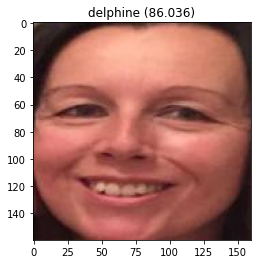

In [270]:
# Carga do jogo de validacao
data = np.load('TWO/datasetRostos.npz')
XVal_faces = data['arr_2']

# Se testa o modelo de classificaca SVC com uma amostra aleatoria do jogo de validaca (nao usado para o treinamento)
selection = choice([i for i in range(XVal.shape[0])])
random_face_pixels = XVal_faces[selection]
random_face_emb = XVal[selection]
random_face_class = YVal[selection]
random_face_name = encoderOut.inverse_transform([random_face_class])

# Predicao de classificacao do rosto da amostra selecionada
samples = np.expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# Recuperacao do nome da classe predita assim que a probabilidade desta predica
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = encoderOut.inverse_transform(yhat_class)

#Apresentacao do rosto e das classes real/predita com a probabilidade
print('Predito: %s (%.3f)' % (predict_names[0], class_probability))
print('Esperado: %s' % random_face_name[0])
# Plot
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()


In [112]:
samples.shape
yhat_class.shape
yhat_prob.shape
yhat_class

array([6])

In [121]:
yhat_prob
model

SVC(kernel='linear', probability=True)

In [51]:
encoderOut.inverse_transform(YVal)

array(['etienne', 'etienne', 'etienne', 'maman', 'maman'], dtype='<U7')

In [86]:
#Se salva o mdelo de classificacao SVM, os encoders do jogo de entrada (normalizacao) e de saida (DE-PARA ID-LABEL classes rosto)

# Modelo SVM
print(f'   -> Objeto SVM Modelo resultando do treinamento:\n      {model}')
#Serializacao do modelo em arquivo da pasta models presente na raiz do projeto
with open(f"models/modelSVC.sav", 'wb') as writeFile:
    pickle.dump(obj=model, file=writeFile)
    
# Encoder do jogo de entrada (normalizacao)
print(f'   -> Objeto encoder IN do jogo de treinamento:\n      {encoderIn}')
# Serializacao do encoder IN
with open(f"models/encoderIn.sav", 'wb') as writeFile:
    pickle.dump(obj=encoderIn, file=writeFile)
    
# Encoder do jogo de saida (de-para id-label classes rostos)
print(f'   -> Objeto encoder OUT do jogo de treinamento:\n      {encoderOut}')
# Serializacao do encoder OUT
with open(f"models/encoderOut.sav", 'wb') as writeFile:
    pickle.dump(obj=encoderOut, file=writeFile)
    



   -> Objeto SVM Modelo resultando do treinamento:
      SVC(kernel='linear', probability=True)
   -> Objeto encoder IN do jogo de treinamento:
      Normalizer()
   -> Objeto encoder OUT do jogo de treinamento:
      LabelEncoder()


# DETECAO E EVENTUALMENTE CLASSIFICACAO ROSTOS DE UMA NOVA FOTO

In [272]:
def embeddingRostos(modelEmbed, lstDicRosto):
    
    #Se transforma os dados dos rostos em uma array numpy de 4 dimensoes 
    # (1era sample, segunda linha, terceira coluna e quarta canal cor)
    lstDataRosto = list()
    for dicRosto in lstDicRosto:
        lstDataRosto.append(dicRosto['data'])
    npDataRosto = np.array(object=lstDataRosto, ndmin=3)
    
    #Preprocessamento dos dados para atender os requisitos do modelo Facenet
    # scale pixel values
    npDataRosto = npDataRosto.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = npDataRosto.mean(), npDataRosto.std()
    npDataRosto = (npDataRosto - mean) / std
    
    #Se realiza a predicao com o modelo Facenet para ter o vector "embedding" de cada rosto
    yhat = modelEmbed.predict(npDataRosto)
    
    npEmbedRosto = yhat
    
    return npEmbedRosto

In [273]:
def classifRostos(modelClassif, encoderIn, encoderOut, npEmbedRosto):

    # VERIFICAR SE PRECISA OU NAO NORMALIZAR COM O ENCODER DO JOGO DE TREINAMENTO, VISTO QUE PARECE DAR UMA PREDICAO DE MAIOR
    # PROBABILIDADE SEM USAR A NORMALIZACAO
    # MAS TEM MAIS FALSOS POSITIVOS...
    #Se normaliza o array de embedding dos rostos, conforme feito para o jogo de treinamento do modelo de classificacao SVC
    XPred = encoderIn.transform(npEmbedRosto)
    #XPred = npEmbedRosto
    
    #Se realiza a predicao de cada rosto a parte do seu vector normalizado de embedding
    # Retorno um ID de classe de rosto dentro da lista de classes treinadas do modelo
    YPred = modelClassif.predict(XPred)
    # Por rosto, calculo da probabilidade de cada classe (a de probabilidade maior corresponde ao ID presente em YPred para o rosto)
    probPred = modelClassif.predict_proba(XPred)
    # Recuperacao, a parte do encoder do jogo de saida, do label da classe predita
    labelPred = encoderOut.inverse_transform(YPred)

    # Trannsformacao em listas para o retorno da funcao
    lstLabelPredRosto = labelPred.tolist()
    lstProbPredRosto = probPred.max(axis=1).round(2).tolist() #Se recupera so a probabilidade maior por rosto
                                                     # correspondendo a classe de ID presente em lstLabelPredRosto
    
    return lstLabelPredRosto, lstProbPredRosto

In [274]:
def getModelos(modelDetect=None, modelEmbed=None, modelClassif = None, encoderIn = None, encoderOut = None):
    
    #  Modelo para detacao dos rostos na fotografia
    if modelDetect is None:
        modelDetect = MTCNN()
    #  Modelo para embedding (=serie de 128 features) dos rostos idenficados na foto
    if modelEmbed is None:
        modelEmbed = load_model('models/facenet_keras.h5')
    #  Modelo para classificacao dos rostos a parte do enbedding (=serie de 128 features) deles
    if modelClassif is None:
        #  Deserializacao do objeto
        with open(f"models/modelSVC.sav", 'rb') as readFile:
            modelClassif = pickle.load(file=readFile)    
    #  Encoder do jogo de entrada no modelo SVC de classificacao (normalizacao do jogo de treinamento) 
    if encoderIn is None:
        #  Deserializacao do objeto
        with open(f"models/encoderIn.sav", 'rb') as readFile:
            encoderIn = pickle.load(file=readFile)  
    #  Encoder do jogo de saida no modelo SVC de classificacao (DE-PARA ID-LABEL classes rosto treinados) 
    if encoderOut is None:
        #  Deserializacao do objeto
        with open(f"models/encoderOut.sav", 'rb') as readFile:
            encoderOut = pickle.load(file=readFile)  
            
    return modelDetect, modelEmbed, modelClassif, encoderIn, encoderOut

In [277]:
#Funcao para detecter e evantualmente classificar o/os eventuais rostos de uma foto, fazendo parte das classes reconhecidas pelo modelo treinado SVC
def detectClassifRostosFoto(pathPhoto, pathRosto = 'TWO', modelDetect=None, modelEmbed=None, modelClassif = None, \
                            encoderIn = None, encoderOut = None, limProbLabel = 0.7):
    print(f'CLASSIFICACAO ROSTOS da imagem {pathPhoto}')
    
    # Carga dos modelos/encoders caso eles nao foram passados em parametro a funcao
    modelDetect, modelEmbed, modelClassif, encoderIn, encoderOut = getModelos(modelDetect, modelEmbed, modelClassif, encoderIn, encoderOut)

    #Tamanho dos rostos esperados pelo modelo de embedding
    sizeRosto = (160, 160)

    try:
        #Se tratar-se bem de um arquivo
        if os.path.isfile(pathPhoto):
            #Nome do arquivo
            nameFile = os.path.basename(pathPhoto)
            print(nameFile)
            
            #Tentativa de carga do arquivo como imagem
            img = Image.open(pathPhoto)
            
            #Eventual rotacao da imagem para estar no bom sentido para a identificacao dos rostos
            img = orientacaoImagem(img)
    
            #Transformacao em array para passar ao extrator de rostos
            dataImg = np.asarray(img)
            
            #Extracao dos rostos da imagem e armazenamento opcional no storage
            lstDicRosto = extracaoRostos(modelDetect, nameFile, dataImg, pathRosto, sizeRosto)
            
            #Calculo da serie de valores caraterisando cada rosto via o modelo Facenet (processo de embedding)
            npEmbedRosto = embeddingRostos(modelEmbed, lstDicRosto)
            
            #Predicao da classe de cada rosto a parte da serie de embeddind destes rostos
            lstLabelPredRosto, lstProbPredRosto = classifRostos(modelClassif, encoderIn, encoderOut, npEmbedRosto)
            
            #Apresentacao da imagem com os rostos delimitados por rectangulo vermelho
            plotImageComRostos(dataImg, lstDicRosto, lstLabelPredRosto, lstProbPredRosto, limProbLabel)
            
            return lstDicRosto, npEmbedRosto, lstLabelPredRosto, lstProbPredRosto
            
    except UnidentifiedImageError:
        print(f'Warning: O arquivo {nameFile} nao pode estar carregado porque nao esta reconhecido como imagem.')
    except OSError:
        print(f'Warning: O arquivo {nameFile} nao pode estar carregado porque gera um erro OS a pesar estar reconhecido como imagem.')
        #print(sys.exc_info()[0])
        print(sys.exc_info())
        raise
    except:
        print(nameFile)
        print("Unexpected error:", sys.exc_info()[0])
        raise

CLASSIFICACAO ROSTOS da imagem isalie-remi-damien-delphine-franck-maman-papa-3.jpg
isalie-remi-damien-delphine-franck-maman-papa-3.jpg


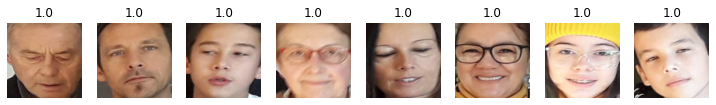

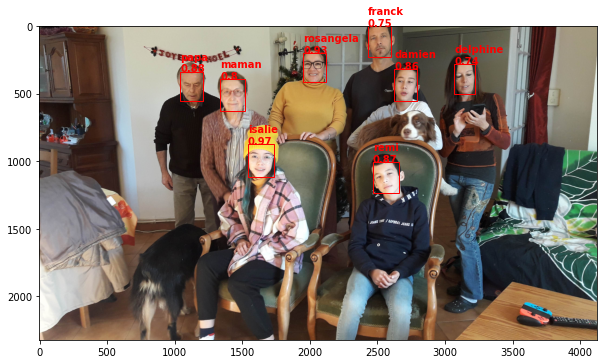

CLASSIFICACAO ROSTOS da imagem isalie-remi-damien-delphine-franck-maman-papa-3.jpg
isalie-remi-damien-delphine-franck-maman-papa-3.jpg


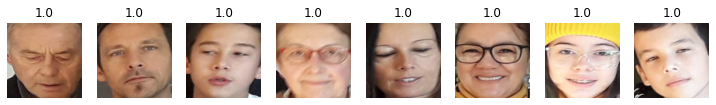

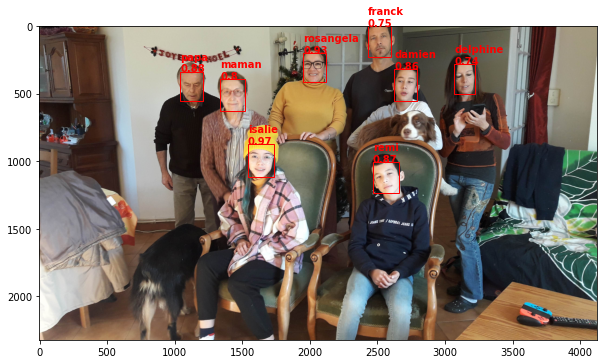

In [278]:


#lstDicRosto, _, _, _ = detectClassifRostosFoto('TWO/test/isalie/WIN_20210905_15_21_31_Pro.jpg', pathRosto = None, limProbLabel = 0.7)

#lstDicRosto, npEmbedRosto, lstLabelPredRosto, lstProbPredRosto = \
#detectClassifRostosFoto('etienne-3.jpg', pathRosto = None, limProbLabel = 0.7)

name='TWO/test/etienne/WIN_20210905_15_17_10_Pro.jpg'
name = 'TWO/test/etienne/WIN_20210905_15_16_45_Pro.jpg'
name='etienne-3.jpg'



name='isalie-remi-damien-delphine-franck-maman-papa-3.jpg'

lstDicRosto, npEmbedRosto, lstLabelPredRosto, lstProbPredRosto = \
detectClassifRostosFoto(name, pathRosto = None, limProbLabel = 0.6)

In [110]:
lstDataRosto = list()

for dicRosto in lstDicRosto:
    lstDataRosto.append(dicRosto['data'])

npDataRosto = np.array(object=lstDataRosto, ndmin=3)

In [115]:
len(lstDataRosto)
lstDataRosto[0]

npDataRosto.shape

(4, 160, 160, 3)

In [120]:
npEmbedRosto.shape

(4, 128)

In [172]:
modelClassif = model
modelClassif
XPred = encoderIn.transform(npEmbedRosto)
YPred = modelClassif.predict(XPred)
ProbPred = modelClassif.predict_proba(XPred)
classPred = encoderOut.inverse_transform(YPred)

In [200]:
npEmbedRosto
XPred
YPred
ProbPred.tolist()
#classPred.tolist()
ProbPred.max(axis=1).tolist()
ProbPred.max(axis=1).round(2).tolist() 

[0.51, 0.82, 0.66, 0.57]

In [198]:
lstLabelPredRosto
lstProbPredRosto

[0.5130464755043211,
 0.8163782001793302,
 0.6628095438009648,
 0.5704261021782528]

In [293]:
#Tentativa de carga do arquivo como imagem
img = Image.open('20180529_144200.jpg')
#Recuperacao dos diferentes tags da foto
exifs = img.getexif()
print(exifs[274])
img = img.rotate(180)
img.show()

3
